In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
import scipy.stats as stats
import databento as db
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.optimize import minimize_scalar
from sklearn.linear_model import Ridge, ElasticNet
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Data (03.07, SPY)

In [4]:
def load_lob_data(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            dataframe = pd.read_parquet(f'C:/Users/Эвелина Новикова/{asset}_{date}.parquet')
            dataframe[f'best_bid_{asset}'] = dataframe['bids[0].price']
            dataframe[f'best_bid_amount_{asset}'] = dataframe['bids[0].amount']
            dataframe[f'best_ask_{asset}'] = dataframe['asks[0].price']
            dataframe[f'best_ask_amount_{asset}'] = dataframe['asks[0].amount']
            dataframe[f'mid_{asset}'] = (dataframe['bids[0].price'] + dataframe['asks[0].price'])/2
            dataframe[f'lob_imbalance_L1_{asset}'] = (dataframe[f'best_bid_amount_{asset}'] - dataframe[f'best_ask_amount_{asset}'])/(dataframe[f'best_bid_amount_{asset}'] + dataframe[f'best_ask_amount_{asset}'] + 1e-12)
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'mid_{asset}': dataframe[f'mid_{asset}'],
                                                          f'best_bid_{asset}': dataframe[f'best_bid_{asset}'],
                                                         f'best_ask_{asset}': dataframe[f'best_ask_{asset}'],
                                                         f'best_bid_amount_{asset}': dataframe[f'best_bid_amount_{asset}'],
                                                         f'best_ask_amount_{asset}': dataframe[f'best_ask_amount_{asset}'],
                                                         f'lob_imbalance_L1_{asset}': dataframe[f'lob_imbalance_L1_{asset}']})
    return dataframes

def make_combined_lob(date):
    combined_lob = data_lob[f'VXX_{date}'].join(data_lob[f'SPY_{date}'], how='outer')\
           .join(data_lob[f'QQQ_{date}'], how='outer')\
           .join(data_lob[f'MRVL_{date}'], how='outer')\
           .join(data_lob[f'ANSS_{date}'], how='outer')\
           .join(data_lob[f'FAST_{date}'], how='outer')\
           .join(data_lob[f'VRSK_{date}'], how='outer')
    return combined_lob.fillna(0)

def regular_lob(combined_lob):
    combined_lob = combined_lob.reset_index()
    combined_lob['datetime'] = pd.to_datetime(combined_lob['datetime'])
    filtered_lob = combined_lob[(combined_lob['datetime'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_lob['datetime'].dt.time < pd.to_datetime('19:55:00').time())]
    return filtered_lob

def calculate_rolling_fts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index('datetime')
    assets = ['ANSS', 'FAST', 'VXX', 'VRSK', 'QQQ', 'SPY', 'MRVL']
    for asset in assets:
        df[f'volatility_{asset}_1'] = df[f'mid_{asset}'].rolling('1min').std().fillna(1e-8)
        df[f'volatility_{asset}_5'] = df[f'mid_{asset}'].rolling('5min').std().fillna(1e-8)
        df[f'volatility_{asset}_30'] = df[f'mid_{asset}'].rolling('30min').std().fillna(1e-8)
    df = df.reset_index()
    return df

In [7]:
data_lob = load_lob_data([20250703])
combined_lob = make_combined_lob(20250703)
lob = regular_lob(combined_lob)
features = calculate_rolling_fts(lob).fillna(0)

In [128]:
# распаковка моделей

vol_SPY = joblib.load('vol_SPY.joblib')
mid_SPY = joblib.load('mid_SPY.joblib')

In [9]:
model_vol_SPY = vol_SPY['model']
model_mid_SPY = mid_SPY['model']

In [10]:
mid_price_SPY = model_mid_SPY.predict(features[['lob_imbalance_L1_SPY', 'mid_SPY']])
sigma_SPY = model_vol_SPY.predict(features[['volatility_SPY_1', 'volatility_QQQ_1']])

In [15]:
data_SPY = pd.DataFrame({'mid_price': mid_price_SPY,
                    'sigma': sigma_SPY})

### Parameters

In [71]:
T = 228000
dt = 1.0
N = int((features['datetime'].iloc[-1] - features['datetime'].iloc[0]).total_seconds()*10 / dt) + 1

In [73]:
A = 140.0
k = 1.5

### Algorithm

In [55]:
def calculate_reservation_prices(sigma: float, T: float, s: float, q: int, t: float, gamma: float) -> Tuple[float, float, float]:
    time_to_expiry = T - t
    r = s - q * gamma * sigma**2 * time_to_expiry

    r_bid = s + (-1 - 2*q) * gamma * sigma**2 * time_to_expiry / 2
    r_ask = s + (1 - 2*q) * gamma * sigma**2 * time_to_expiry / 2

    return r, r_bid, r_ask

def calculate_optimal_spread(T: float, gamma: float, t: float, k: float, sigma: float) -> float:
    time_to_expiry = T - t
    
    if time_to_expiry <= 0:
        return 0.0
    if gamma <= 0:
        return 0.0
        
    try:
        spread = gamma * sigma**2 * time_to_expiry + (2/gamma) * np.log(1 + gamma/k)
    except (OverflowError, ZeroDivisionError):
        spread = gamma * sigma**2 * time_to_expiry
    
    return max(spread, 0.01) 

def calculate_order_intensity(A: float, k: float, delta: float) -> float:
    if delta <= 0:
        return A

    try:
        intensity = A * np.exp(-k * delta)
    except OverflowError:
        intensity = 0.0
    return max(intensity, 0.0)

def simulate_strategy(df: pd.DataFrame, strategy_type: str, gamma: float, T: float, dt: float, A: float, k: float, N: float) -> Dict:
    price_path = df['mid_price']
    sigma_path = df['sigma']
    inventory = 0
    cash = 0.0

    inventory_history = []
    pnl_history = []
    n_steps = N
    for i in range(n_steps):
        t = i * dt
        s = price_path[i]
        sigma = sigma_path[i]
        r, r_bid, r_ask = calculate_reservation_prices(sigma, T, s, inventory, t, gamma)
        total_spread = calculate_optimal_spread(T, gamma, t, k, sigma)

        if strategy_type == 'inventory':  # Center around reservation price
                
            bid_price = r - total_spread / 2
            ask_price = r + total_spread / 2
                
        elif strategy_type == 'symmetric':  # Center around mid-price
                
            bid_price = s - total_spread / 2
            ask_price = s + total_spread / 2
        else:
            raise ValueError(f"Unknown strategy type: {strategy_type}")

        delta_bid = s - bid_price
        delta_ask = ask_price - s

        # Ensure positive spreads
        delta_bid = max(delta_bid, 0.01)
        delta_ask = max(delta_ask, 0.01)

        lambda_bid = calculate_order_intensity(A, k, delta_bid)
        lambda_ask = calculate_order_intensity(A, k, delta_ask)

        # Simulate order arrivals (Poisson process)
        prob_bid = min(lambda_bid * dt, 1.0)
        prob_ask = min(lambda_ask * dt, 1.0)

        bid_order = np.random.random() < prob_bid
        ask_order = np.random.random() < prob_ask

        if bid_order:
            inventory += 1
            cash -= bid_price

        if ask_order:
            inventory -= 1
            cash += ask_price

        pnl = cash + inventory * s
                
        inventory_history.append(inventory)
        pnl_history.append(pnl)

    # Final P&L calculation
    final_price = price_path[N-1]
    final_pnl = cash + inventory * final_price

    return {'pnl': pnl_history, 'inventory': inventory_history}

## Results

### Gamma = 0.01

In [75]:
res_inv_001 = simulate_strategy(data_SPY, 'inventory', 0.01, T, dt, A, k, N)
res_sym_001 = simulate_strategy(data_SPY, 'symmetric', 0.01, T, dt, A, k, N)

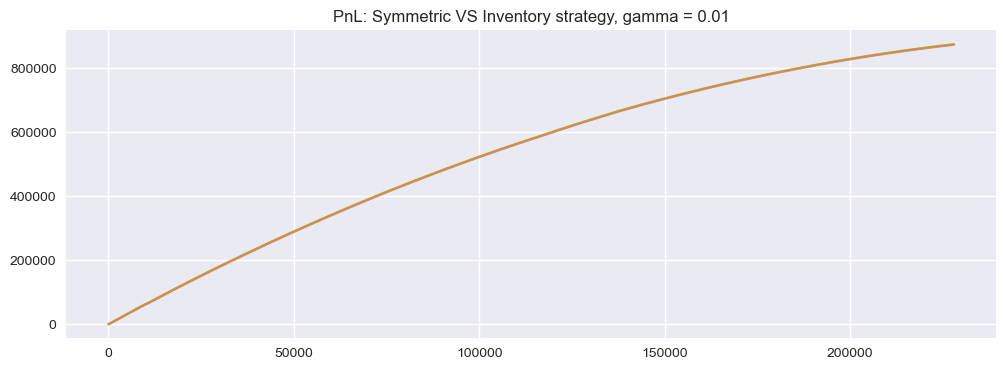

In [105]:
plt.figure(figsize=(12, 4))
plt.plot(res_inv_001['pnl'], alpha=0.8)
plt.plot(res_sym_001['pnl'], alpha=0.8)
plt.title('PnL: Symmetric VS Inventory strategy, gamma = 0.01')
plt.grid(True)
plt.show()

### Gamma = 0.05

In [76]:
res_inv_005 = simulate_strategy(data_SPY, 'inventory', 0.05, T, dt, A, k, N)
res_sym_005 = simulate_strategy(data_SPY, 'symmetric', 0.05, T, dt, A, k, N)

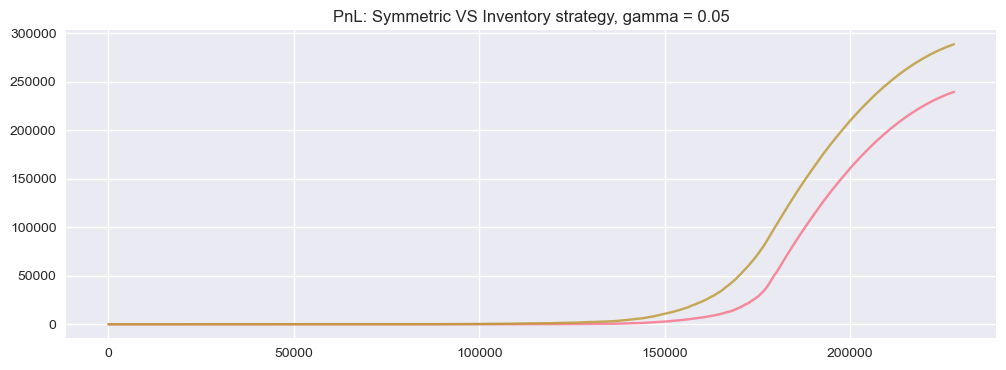

In [107]:
plt.figure(figsize=(12, 4))
plt.plot(res_inv_005['pnl'], alpha=0.8)
plt.plot(res_sym_005['pnl'], alpha=0.8)
plt.title('PnL: Symmetric VS Inventory strategy, gamma = 0.05')
plt.grid(True)
plt.show()

### Gamma = 0.1

In [77]:
res_inv_01 = simulate_strategy(data_SPY, 'inventory', 0.1, T, dt, A, k, N)
res_sym_01 = simulate_strategy(data_SPY, 'symmetric', 0.1, T, dt, A, k, N)

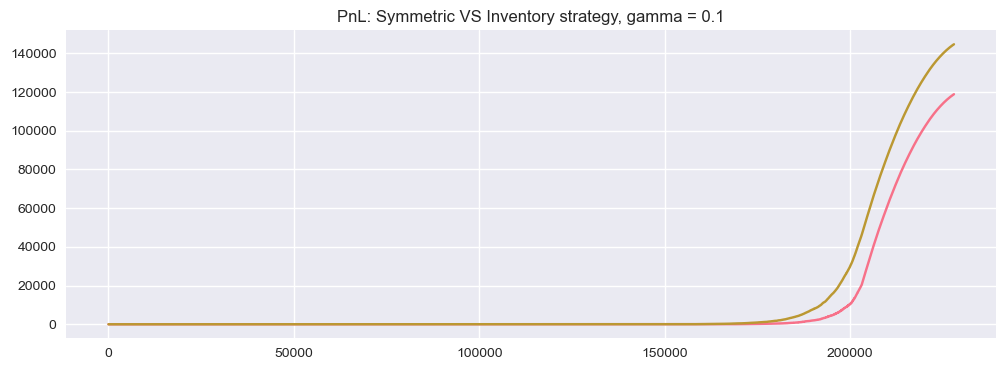

In [121]:
plt.figure(figsize=(12, 4))
plt.plot(res_inv_01['pnl'], label="Inventory")
plt.plot(res_sym_01['pnl'], label='Symmetric')
plt.title('PnL: Symmetric VS Inventory strategy, gamma = 0.1')
plt.grid(True)
plt.show()

При увеличении параметра риск-аверсии результаты тестирования стратегий начинают расходиться. На исторических данных, как и на сгенерированных, симметричная стратегия даёт, в среднем, больший PnL, но с большим стандартным отклонением, чем у инвентарной. Плюс инвентарной стратегии - возможность калибровки параметра риск-аверсии для максимизации Sharpe Ratio (нужно подобрать параметр гамма так, чтобы найти наиболее оптимальное соотношение ожидаемой доходности к риску), это будет завершающий шаг в исследовании.

Дальнейшие шаги:
1. Попробовать новую модель TabNet предсказания мидпрайса и волатильности
2. Попробовать скомбинировать Elastic Net с трансформером
3. Сделать возможным онлайн-обучение модели
4. Подумать над внедрением среднесрочных и долгосрочных временных фичей: новости, перерывы на других биржах, реакция ликвидности активов на приближение :00 минут каждого часа, и т.д.
5. Написать пайплайн калибровки интенсивности исполнения заявок по данным сделок
6. Полный бэктест на большой выборке (нужны актуальные данные)